# Variational Autoencoders (VAE): Implementation
---
This file contains the main codes that we implemented to produce the result that we presented in our report titled **"Experimenting With Variational Auto Encoders"**. Note that some parts of the codes has been run in parallel to produce the results and hence we are just presenting a sample of what we have done. For example in the case of comparison between different models of increasing feature map size, we have an "if statement" that can recognize which approach to use. Then by allowing certain "if statement" to be true, we use that approach in increasing feature map size. 
This implementation is presented here in $2$ main parts as follows:


1.  **Initialization and Helper Functions:** In this section we upload the data, the needed libraries, and implement our helper functions.
2.   **Model:** This section is where the model is built, trained, and produces the needed results for the analysis in the report.



## 1. Initialization and Helper Functions

### 1.1 Loading Needed Libraries
Below the needed libraries and dependencies are being loaded.

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.image as matimg
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.layers.core import Activation
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply, Reshape, Conv2D,Conv2DTranspose,MaxPooling2D,UpSampling2D
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras import optimizers
import glob, os

### 1.2 Loading Data
Below the "celebA" data set is being loaded. Note that since the data is large and we are using Google Colaboratory for our implementations we could not load the entire data set. Instead we are loading only $10,000$ training points and $1,000$ validation points instead.

In [0]:
from google.colab import files
uploaded = files.upload()

Saving dataset.tar.gz to dataset.tar.gz


In [0]:
!tar -xf dataset.tar.gz
!ls

datalab  dataset  dataset.tar.gz


In [0]:


def load_image(path):
    image = matimg.imread(path)    
    return image


def load_local_data(path):
    paths = glob.glob(os.path.join(path + "/train", "*.jpg"))
    X_train = np.array( [ load_image(p) for p in paths ] )

    paths = glob.glob(os.path.join(path + "/test", "*.jpg"))
    X_test = np.array( [ load_image(p) for p in paths ] )

    return X_train, X_test
  

(x_train_color, x_test_color) = load_local_data("dataset")
    
x_train_color = x_train_color.astype('float32') / 255.
x_test_color = x_test_color.astype('float32') / 255.

x_train_color = x_train_color.reshape(x_train_color.shape[0],64*64*3)
x_test_color = x_test_color.reshape(x_test_color.shape[0],64*64*3)

print("train data size is:")
print(x_train_color.shape)

print("test data size is:")
print(x_test_color.shape)


train data size is:
(10000, 12288)
test data size is:
(1000, 12288)


### 2.3 Helper Functions
Below we have our helper functions that will help us in the upsampling process.

In [0]:

def UpSample_BiLinear(x):
  return tf.image.resize_images(x, size=(64,64), method=tf.image.ResizeMethod.BILINEAR,align_corners=False)

def UpSample_NN(x):
  return tf.image.resize_images(x, size=(64,64), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR,align_corners=False)


## 2. Model
Below we are building/training our VAE model. Note that Vanilla-VAE is simply an IWAE with Monte-Carlo sample size of $1$. In our code the variable **mc_samples** is responsible for the number of Monte-Carlo samples we need, this helps us with the analysis needed when comparing Vanilla-VAE ($\mathrm{mc\_sample}=1$) with IWAE ($\mathrm{mc\_sample}=5$). We also indicated our method of increasing feature map size by setting the variable **upsampling_type** to either $1, 2$ or $3$ representing:


1.   Deconvolution (transposed convolution) with paddings and strides
2.   Nearest-Neighbor Upsampling followed by regular convolution
3.  Bilinear Upsampling followed by regular convolution

The change in the value of **upsampling_type** helps us analyze the different schemes of increasing feature map size.  


In [0]:


mc_samples = 1
batch_size = 128
original_dim = 12288
latent_dim = 100
epochs = 200
epsilon_std = 1.0

#Can be either:
#1 -> Deconv
#2 -> NN
#3 -> Bilinear
upsampling_type=1

def nll(y_true, y_pred):
    """ Bernoulli negative log likelihood. """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. We require the sum.
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

x = Input(shape=(original_dim,))

#Encoder in Action

tenc1=Reshape((64,64,3), input_shape=(original_dim,))

tenc2=Conv2D(128, (5, 5), padding='same')
tenc3=MaxPooling2D(pool_size=(8, 8)) #64->8
tenc4=Activation('relu')

tenc5=Conv2D(256, (5,5) ,padding='same' )
tenc6=MaxPooling2D(pool_size=(8, 8)) #64->8
tenc7=Activation('relu')

tenc8=Reshape((256*1*1,), input_shape=(1,1,256))
tenc12=Dense(1024, activation='relu')

tenc_1=tenc1(x)
tenc_2=tenc2(tenc_1)
tenc_3=tenc3(tenc_2)
tenc_4=tenc4(tenc_3)
tenc_5=tenc5(tenc_4)
tenc_6=tenc6(tenc_5)
tenc_7=tenc7(tenc_6)
tenc_8=tenc8(tenc_7)
tenc_9=tenc12(tenc_8)

z_mu = Dense(latent_dim)(tenc_9)
z_log_var = Dense(latent_dim)(tenc_9)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                   shape=(K.shape(x)[0],
                                          mc_samples,
                                          latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])
if upsampling_type==1:
  decoder = Sequential([
      Dense(16*16*256, input_dim=latent_dim, activation='relu'),
      Reshape((-1,16,256)),
      BatchNormalization(),
      Conv2DTranspose(128,(5,5),strides=(2, 2), padding='same'),
      Activation('relu'),
      Conv2DTranspose(3,(5,5),strides=(2, 2), padding='same'),
      Activation('sigmoid'),
      Reshape((-1,original_dim))
  ])
if upsampling_type==2:
    decoder = Sequential([
      Dense(16*16*256, input_dim=latent_dim, activation='relu'),
      Reshape((-1,16,256)),
      BatchNormalization(),
      Lambda(UpSample_NN, output_shape=(32,32,256)),
      Conv2D(128, (5, 5), padding='same'),
      Activation('relu'),
      Lambda(UpSample_NN, output_shape=(64,64,128)),
      Conv2D(3, (5, 5), padding='same'),
      Activation('sigmoid'),
      Reshape((-1,original_dim))
  ])
if upsampling_type==3:
      decoder = Sequential([
      Dense(16*16*256, input_dim=latent_dim, activation='relu'),
      Reshape((-1,16,256)),
      BatchNormalization(),
      Lambda(UpSample_BiLinear, output_shape=(32,32,256)),
      Conv2D(128, (5, 5), padding='same'),
      Activation('relu'),
      Lambda(UpSample_BiLinear, output_shape=(64,64,128)),
      Conv2D(3, (5, 5), padding='same'),
      Activation('sigmoid'),
      Reshape((-1,original_dim))
  ])  
decoder.summary()
print('********************','Decoder Summary is over Now','********************')
x_pred = decoder(z)
vae = Model(inputs=[x, eps], outputs=x_pred)
adam=optimizers.Adam(lr=0.002, beta_1=0.5, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
vae.compile(optimizer=adam, loss=nll)
vae.summary()

history_1=vae.fit(
    x_train_color,
    np.expand_dims(x_train_color, axis=1),
    shuffle=True,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(
        x_test_color,
        np.expand_dims(x_test_color, axis=1)
    )
)


### 2.1 Plots
Below we are plotting the training and validation loss. These plots will be used in the report for further analysis of the topic.

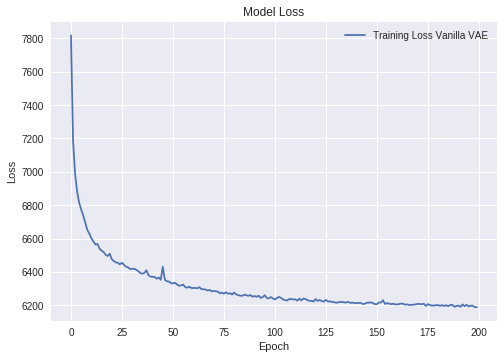

In [0]:
plt.plot(history_1.history['loss'],label='Training Loss Vanilla VAE')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


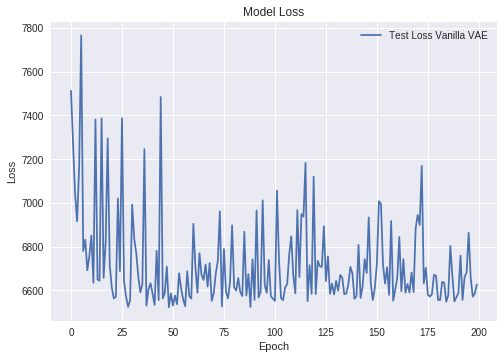

In [0]:
plt.plot(history_1.history['val_loss'],label='Test Loss Vanilla VAE')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### 2.2 Saving Some Data
Here we are saving/downloading the loss values since our models are running in parallel so we can later on upload them and produce some graphs for further analysis.

In [0]:
np.savetxt("val_loss_deconv_MC5.txt",history_1.history['val_loss'])
!ls
files.download("val_loss_deconv_MC5.txt")


In [0]:
np.savetxt("train_loss_deconv_MC5.txt",history_1.history['loss'])
!ls
files.download("train_loss_deconv_MC5.txt")


### 2.3 Quality Inspection
Below we are producing some samples using our model. This is helpful when we need to inspect the quality of our images under different models. For example when we needed to compare the quality of the images under different schemes of increasing the feature map size. This is the main code used to produce the figure $[2]$ of the report.

In [0]:
#paths = glob.glob(os.path.join("dataset/test", "*.jpg"))
paths = ['dataset/test/000128.jpg', 'dataset/test/000504.jpg']
#print(paths)
x1 = np.array( [ load_image(p) for p in paths ] )

x1 = x1.astype('float32') / 255.
  
#x1 = x_test_color[0:3,:]
print(x1.shape)
x1_res = vae.predict(x1.reshape(2,64*64*3))
print(x1_res.shape)

for i in range(0,2):
  print(i)
  print(paths[i])
  plt.imshow(x1[i].reshape(64,64,3))
  plt.show()
  
  plt.imshow(x1_res[i].reshape(64,64,3))
  plt.show()

### 2.4 Playing with $z$
Here is the code to inflict changes in the latent space $z$ and visually monitor the changes. This is the main code used to produce the figure  $[5]$  of the report.

Tensor("input_7:0", shape=(?, 12288), dtype=float32)
(1, 100)
[[ 2.0375226  -1.3476101   0.2723149   0.03990978 -0.23488873  0.02751939
   0.00986713  1.0320044  -0.54313445 -0.88462746 -0.24670205  1.147868
   1.0947149  -0.30981502  0.48228103 -0.12687477 -0.6857087  -0.4335345
  -2.7854185   0.4255818   1.177196   -1.3472074  -0.29707018 -0.8511448
   0.10243919  0.021285    0.7317735   0.60387427 -0.20424378 -2.3515804
   0.63489175 -0.4345595  -0.64116055  1.6796145  -1.1611986  -0.6329616
  -2.2155569   0.17759566 -0.09136956  1.6610693  -0.5459708  -0.12270494
  -1.758049   -0.6486074  -1.7889174   2.7519512   0.43273455 -1.0334537
  -0.1964994  -0.18384497 -0.28161335 -1.3171285   0.9803629   0.7862989
  -1.7875237   0.7249083  -0.808501    0.28284636 -0.73942    -0.28517494
  -1.1103069   1.247131   -0.6506776  -0.5077535  -0.4611671   1.6825213
  -1.1628803   0.3939576  -0.47140005  0.08414986 -1.119237   -0.9276577
   2.1345463  -1.0103984   0.03073943  2.5902126   1.8393275

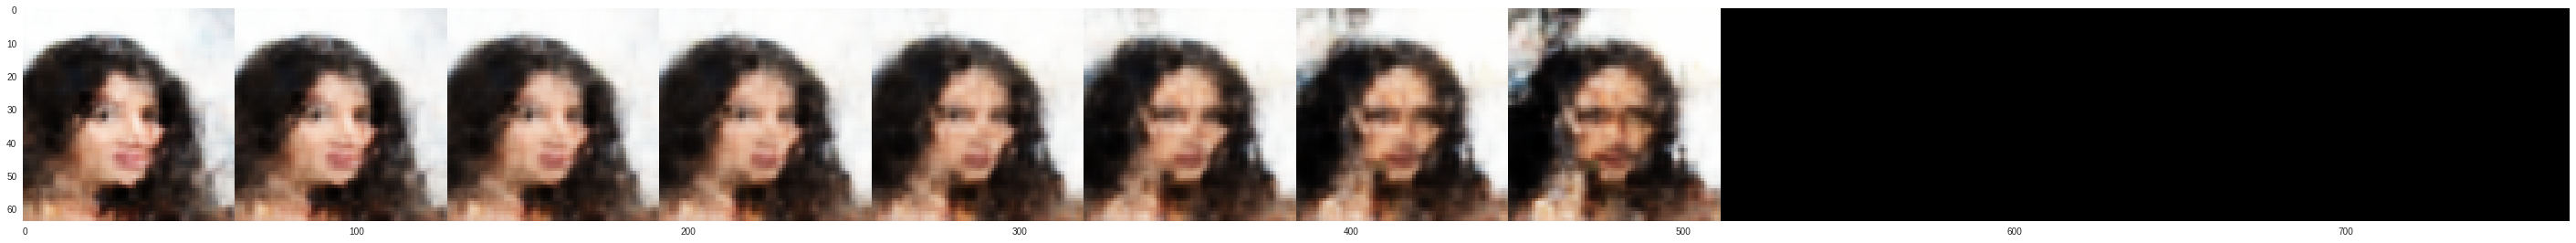

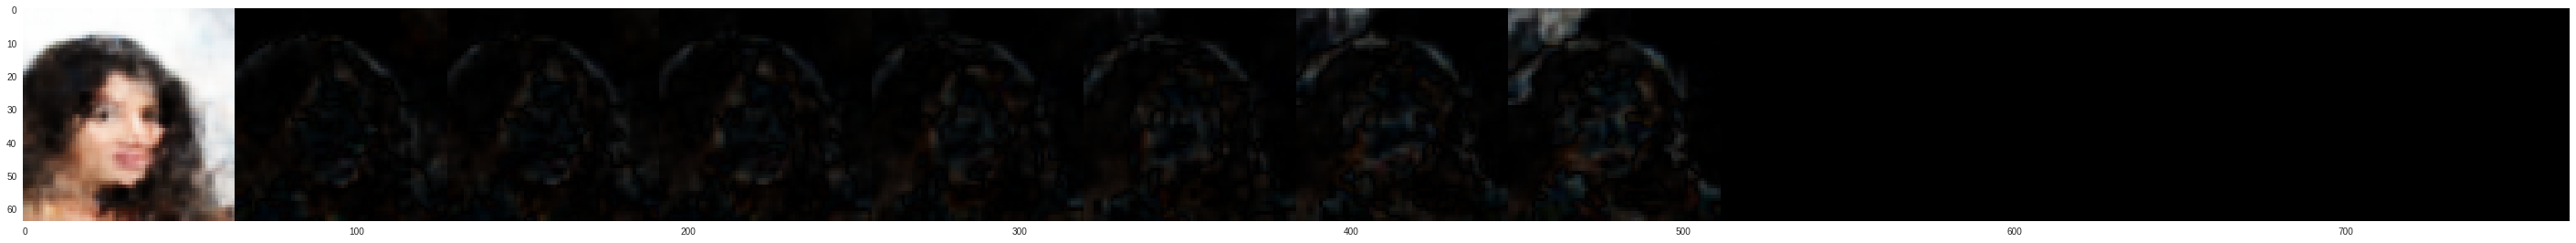

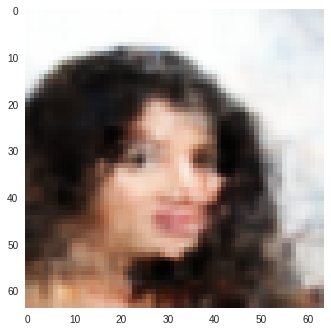

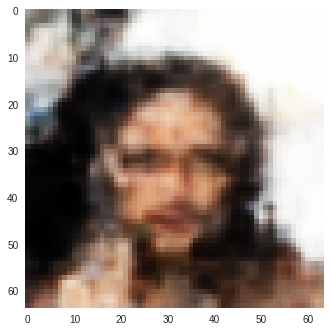

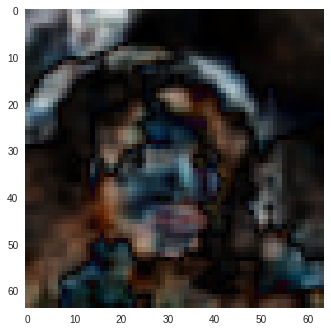

In [0]:
import cv2
digit_size = 64
#Playing with Z dimensions
print(x)
print(z.shape)
#print(vae.summary())
encoder_model = K.function([vae.layers[0].input],[vae.layers[16].output]) #Model(x,z)

#select X 
paths = ['dataset/test/000612.jpg', 'dataset/test/000864.jpg']
x1 = np.array( [ load_image(p) for p in paths ] )
x1 = x1.astype('float32') / 255.
z1 = encoder_model([x1.reshape(2,64*64*3)])[0]
z_1 = z1[0,:]
z_2 = z1[1,:]

j=0
#z_1 = np.random.rand(100)
 
print(z_1)
for n in range(66,67):
  z_1_prim = z_1.reshape([1,100])
  #pre_val = z_1_prim[0,n] 
  j=0
  figure1 = np.zeros((digit_size * 1, digit_size * 12,3))
  figure2 = np.zeros((digit_size * 1, digit_size * 12,3)) #differences
  prev_res = np.zeros([64,64,3])
  #print(z_1_prim[0,n])
  
  num=-1
  generator = decoder
  for val in np.arange(-6,6,1.5):  
    num=num+1
    
    z_1_prim[0,n] =  val

    z_1_prim_res = generator.predict(z_1_prim).reshape(64,64,3)   
    figure1[:,j * digit_size: (j + 1) * digit_size,:] = z_1_prim_res  
    
    newImg = np.abs(z_1_prim_res - prev_res)    
    figure2[:,j * digit_size: (j + 1) * digit_size,:] = newImg    
    prev_res = z_1_prim_res
    
    j=j+1
    
    if num==0:      
      First_Image = z_1_prim_res
  #z_1_prim[0,n] = pre_val  
    
  plt.figure(figsize=(50, 10))
  plt.imshow(figure1, cmap='Greys_r')
  plt.show()


  plt.figure(figsize=(50, 10))
  plt.imshow(figure2, cmap='Greys_r')
  plt.show()

  #main image
  plt.imshow(First_Image)
  plt.show()

  #after all changes
  plt.imshow(z_1_prim_res)
  plt.show()

  #whole diff
  plt.imshow(np.abs(First_Image - z_1_prim_res)  )
  plt.show()


### 2.5 Interpolation
This is the code we used to perform the different methods of interpolation on images. This is the main code used to produce the figure  $[6]$  of the report.

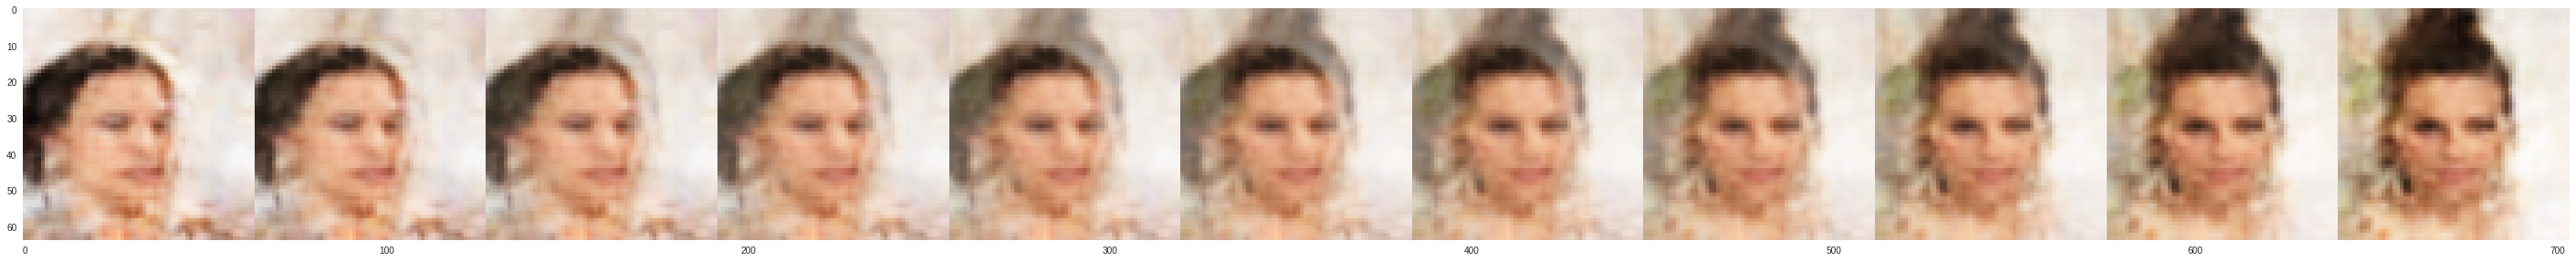

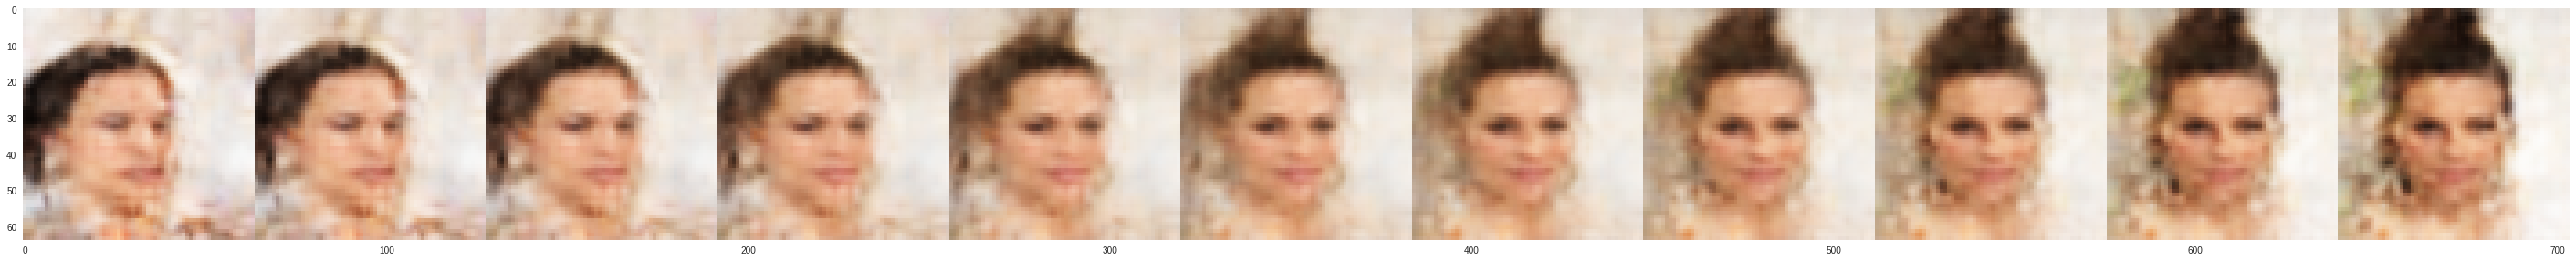

In [0]:
# combination
alphas = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
#encoder_model = Model(x,z)

#select X 
paths = ['dataset/test/000532.jpg', 'dataset/test/000086.jpg']
#paths = ['dataset/test/000292.jpg', 'dataset/test/000139.jpg']
x1 = np.array( [ load_image(p) for p in paths ] )
x1 = x1.astype('float32') / 255.

z1 = encoder_model([x1.reshape(2,64*64*3)])[0]

x_1 = x1[0,:]
x_2 = x1[1,:]

z_1 = z1[0,:] #np.random.rand(100)#   np.zeros(100) 
z_2 =  z1[1,:]# np.ones(100) # np.random.rand(100)#

x1_res = vae.predict(x_1.reshape(1,64*64*3))
x2_res = vae.predict(x_2.reshape(1,64*64*3))

z_1_res = generator.predict(z_1.reshape([1,100]))
z_2_res = generator.predict(z_2.reshape([1,100]))

#plt.imshow(x1_res.reshape([64,64,3]), cmap='Greys_r')
#plt.show() 
#plt.imshow(x2_res.reshape([64,64,3]), cmap='Greys_r')
#plt.show() 

#plt.imshow(z_1_res.reshape([64,64,3]), cmap='Greys_r')
#plt.show() 
#plt.imshow(z_2_res.reshape([64,64,3]), cmap='Greys_r')
#plt.show() 

n=11
figure1 = np.zeros((digit_size * 1, digit_size * n,3))
figure2 = np.zeros((digit_size * 1, digit_size * n,3))

j=0

#print(generator.summary())
for alpha in alphas:
  z_res_combination = alpha*z_1_res + (1-alpha)*z_2_res
  
  z_combination = alpha*z_1 + (1-alpha)*z_2
  z_combination = z_combination.reshape([1,100])
  
  z_combination_res = generator.predict(z_combination)
    
  figure1[:,j * digit_size: (j + 1) * digit_size,:] = z_res_combination.reshape(64,64,3)
  figure2[:,j * digit_size: (j + 1) * digit_size,:] = z_combination_res.reshape(64,64,3)
  
  j=j+1
  
#print(figure1)  
plt.figure(figsize=(50, 10))
plt.imshow(figure1, cmap='Greys_r')
plt.show()  

plt.figure(figsize=(50, 10))
plt.imshow(figure2, cmap='Greys_r')
plt.show()

